# Plot average causal effects & Frozen-MLP causal tracing

In this notebook we run the causal tracing program, safe the results and plot the average causal effects for better visualization of the effects as well as the causal effects with isolated / frozen MLP modules

Model here is: gpt2-medium fine tuned for math

Average over the first 100 math prompts

# Plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [8]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone --branch math-medium --single-branch https://github.com/khnhenriette/ProjectADL rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [11]:
!pip install datasets

## Before running this cell: put causal_trace.py in main folder of rome for the whole thing to run -- directory issues otherwise

In [12]:
!mv /content/rome/experiments/causal_trace.py /content/rome


In [13]:
# run the causal tracing on 100 factual associtations on gpt medium

!python causal_trace.py

2024-12-07 18:34:27.529636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 18:34:27.549370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 18:34:27.555226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 18:34:27.570004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 18:34:28.807836: W tensorflow/compiler/tf2

In [6]:
#!zip -r intermediate_results_gpt2-medium-math.zip /content/rome/results
#!mv intermediate_results_gpt2-medium-math.zip /content/drive/MyDrive/


  adding: content/rome/results/ (stored 0%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/ (stored 0%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/ (stored 0%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/ (stored 0%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/knowledge_0.npz (deflated 48%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/knowledge_1_mlp.npz (deflated 48%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/knowledge_4_mlp.npz (deflated 48%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/knowledge_2_mlp.npz (deflated 48%)
  adding: content/rome/results/ns3_r0__content_drive_MyDrive_gpt2_finetuned_hpo/causal_trace/cases/knowledge_3_at

Now that we have the results of the causal tracing in memory we can access them and plot the averaging figures to get a good overview of the average indirect effects of individual model components over a sample of 100 factual statements.

Make sure results folder has the correct name before running this cell!

Average Total Effect 0.6004076155995105
Best average indirect effect on mathematical operator 0.5103850516651843
Best average indirect effect on last token 0.6004076155995105
Average best-fixed score 0.79200274
Average best-fixed on mathematical operator token score 0.6864038
Average best-fixed on last token score 0.7823482
Argmax at mathematical operator token 0
Max at mathematical operator token 0.63776
Argmax at last prompt token 23
Max at last prompt token 0.72778255


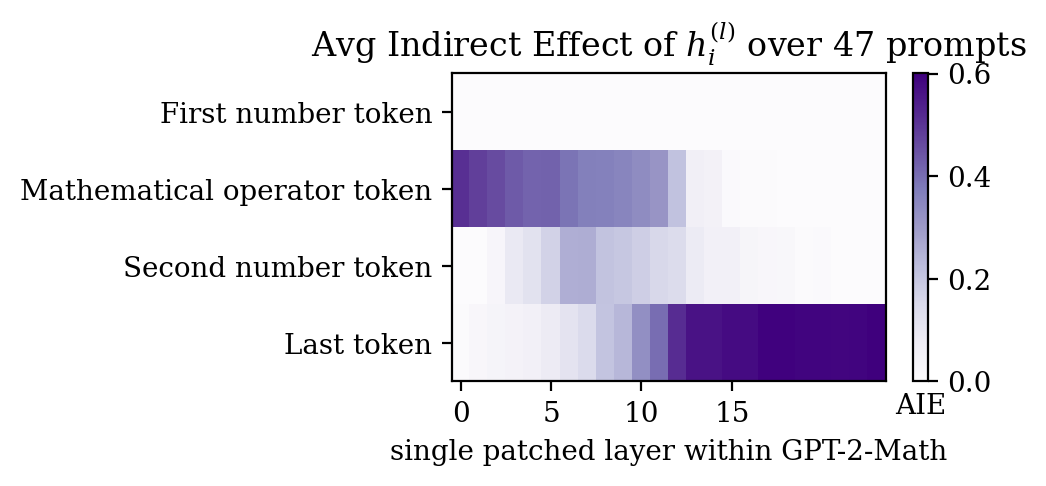

Average Total Effect 0.6004076155995105
Best average indirect effect on mathematical operator 0.514126852450249
Best average indirect effect on last token 0.6300156864498828
Average best-fixed score 0.8258288
Average best-fixed on mathematical operator token score 0.6831147
Average best-fixed on last token score 0.81102777
Argmax at mathematical operator token 5
Max at mathematical operator token 0.6415018
Argmax at last prompt token 20
Max at last prompt token 0.7573906


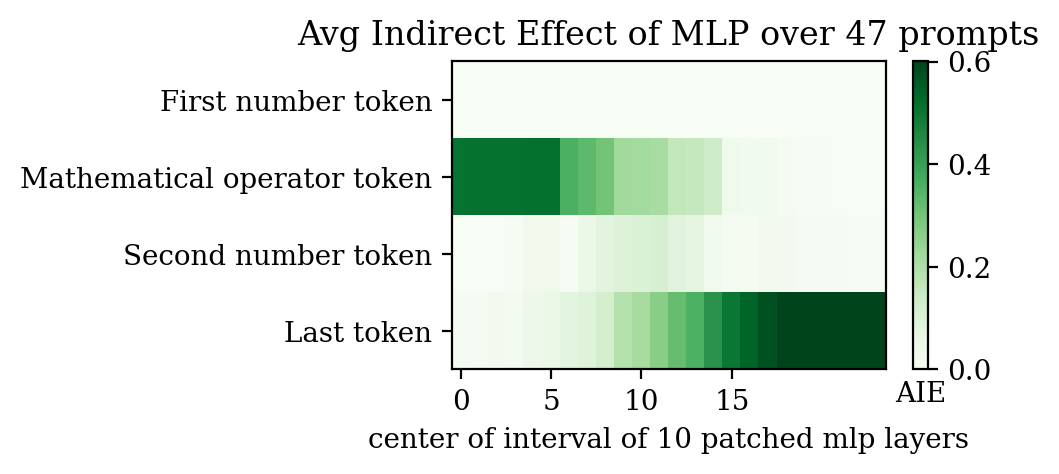

Average Total Effect 0.6004076155995105
Best average indirect effect on mathematical operator 0.05150958925235019
Best average indirect effect on last token 0.578999534544823
Average best-fixed score 0.7692534
Average best-fixed on mathematical operator token score 0.2052545
Average best-fixed on last token score 0.7671737
Argmax at mathematical operator token 0
Max at mathematical operator token 0.17888452
Argmax at last prompt token 14
Max at last prompt token 0.70637447


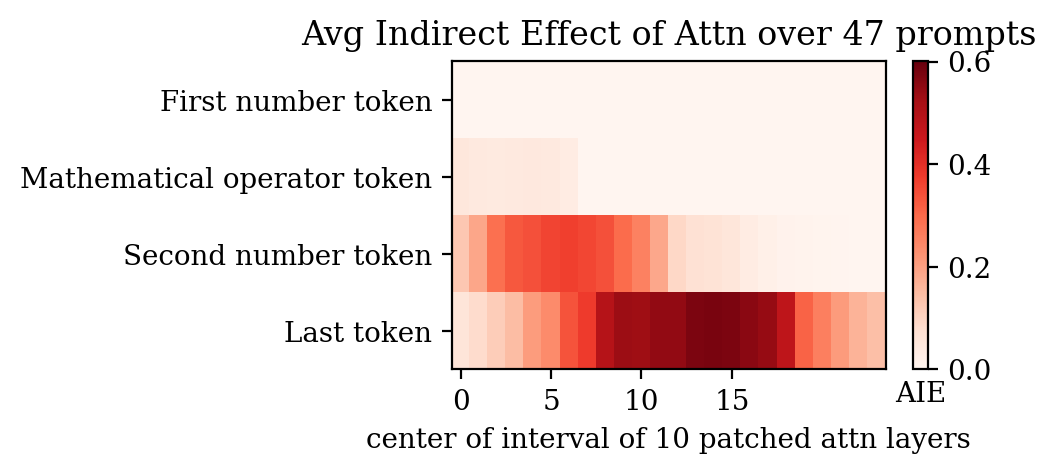

In [17]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "gpt2-medium-math"
archname = "GPT-2-Math"

# arch = "gpt2-xl"
# archname = "GPT-2-XL"

# arch = "EleutherAI_gpt-j-6B"
# archname = "GPT-J-6B

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'


class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-medium-math"):
    dirname = f"results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fn, #first number
        avg_mo, #first mathematical operator token
        avg_sn, #second number
        avg_e, #equals
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(9)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"] # subject (one or two tokens)
        # last_e = first_a - 1 # second subject token --> ignored here
        first_n = first_e - 1 # first number
        last_a = len(scores) - 1 # equals / last token
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[first_e].max()) # fle now for math operator
        avg_fla.add(scores[last_a].max())
        # first number
        avg_fn.add(scores[first_n])
        # mathematical operator
        avg_mo.add(scores[first_e])
        # second number
        avg_sn.add(scores[first_a])
        # equals
        avg_e.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fn.avg(),
            avg_mo.avg(),
            avg_sn.avg(),
            avg_e.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fn.std(),
            avg_mo.std(),
            avg_sn.std(),
            avg_e.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on mathematical operator",
        avg_mo.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_e.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on mathematical operator token score", avg_fle.avg())
    print("Average best-fixed on last token score", avg_fla.avg())
    print("Argmax at mathematical operator token", numpy.argmax(avg_mo.avg()))
    print("Max at mathematical operator token", numpy.max(avg_mo.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_e.avg()))
    print("Max at last prompt token", numpy.max(avg_e.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_mo.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-Math",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First number token",
        "Mathematical operator token",
        "Second number token",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

# there are 1209 factual associations in the knowns dataset, i.e. numbered from 0 to 1208
# we only included the first 100 here
#the_count = 1208
the_count = 100
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

Reading None
Average Total Effect 0.6004076155995105
Best average indirect effect on mathematical operator 0.5103850516651843
Best average indirect effect on last token 0.6004076155995105
Average best-fixed score 0.79200274
Average best-fixed on mathematical operator token score 0.6864038
Average best-fixed on last token score 0.7823482
Argmax at mathematical operator token 0
Max at mathematical operator token 0.63776
Argmax at last prompt token 23
Max at last prompt token 0.72778255
Reading mlp
Average Total Effect 0.6004076155995105
Best average indirect effect on mathematical operator 0.514126852450249
Best average indirect effect on last token 0.6300156864498828
Average best-fixed score 0.8258288
Average best-fixed on mathematical operator token score 0.6831147
Average best-fixed on last token score 0.81102777
Argmax at mathematical operator token 5
Max at mathematical operator token 0.6415018
Argmax at last prompt token 20
Max at last prompt token 0.7573906
Reading attn
Average To

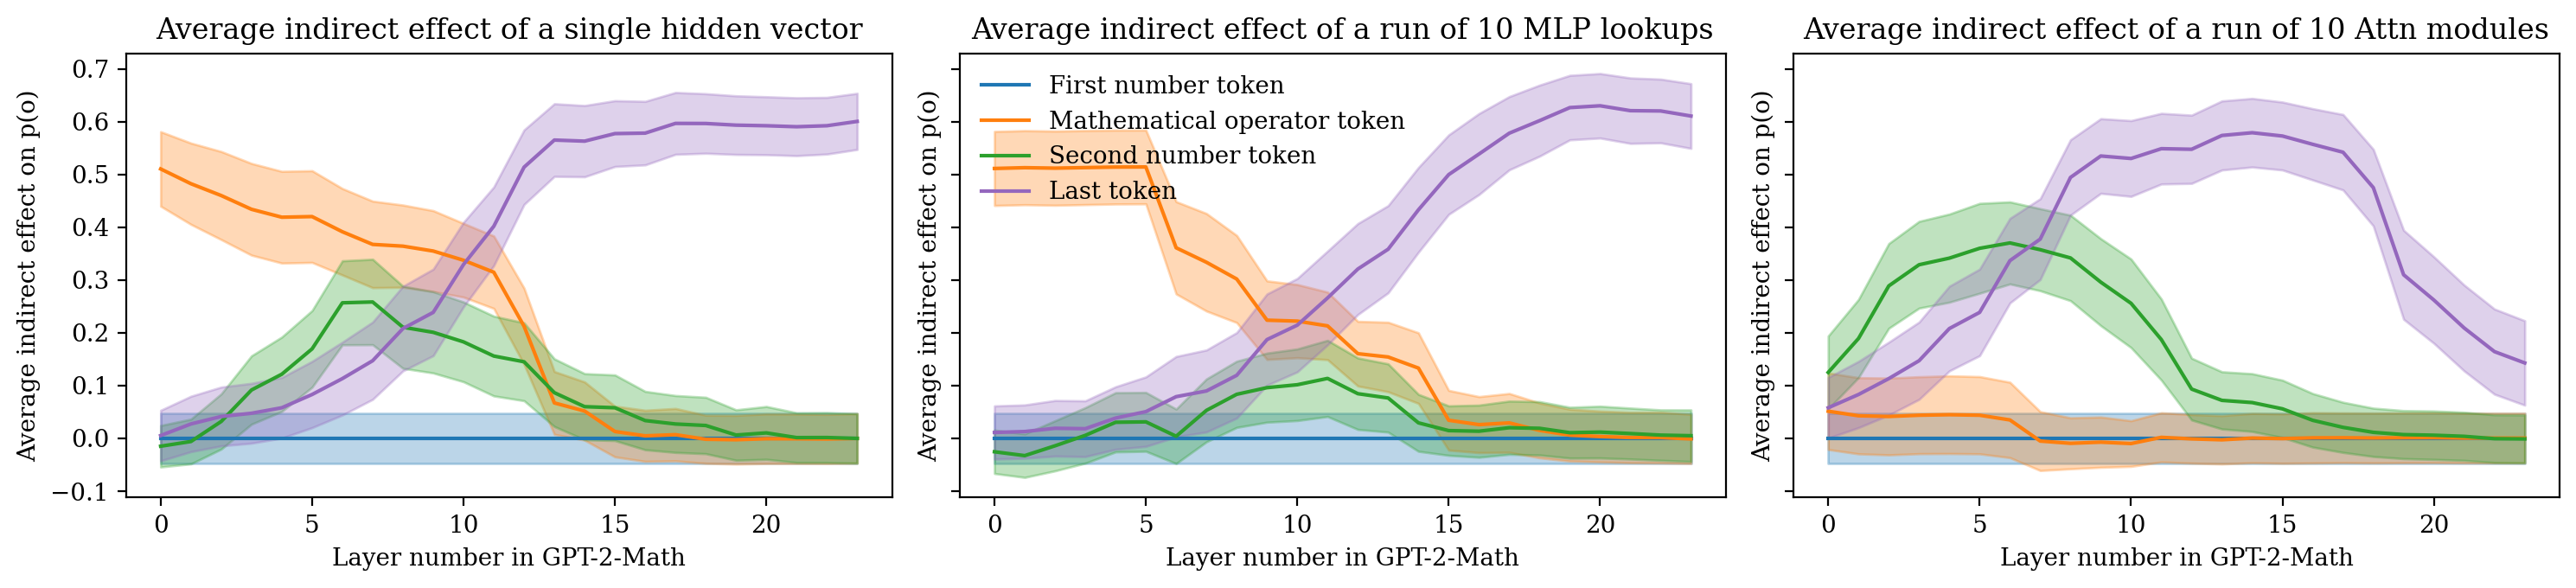

In [34]:
import math


### still need to adapt this

labels = [
    "First number token",
    "Mathematical operator token",
    "Second number token",
    "Last token",
]
color_order = [0, 1, 2, 4]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(100, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()

In [35]:
!zip -r results_gpt2-medium-math.zip /content/rome/results/gpt2-medium-math


  adding: content/rome/results/gpt2-medium-math/ (stored 0%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/ (stored 0%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/ (stored 0%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_20.npz (deflated 70%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_64_attn.npz (deflated 48%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_52_mlp.npz (deflated 67%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_59_mlp.npz (deflated 70%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_74_attn.npz (deflated 70%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_83.npz (deflated 70%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/knowledge_44_mlp.npz (deflated 70%)
  adding: content/rome/results/gpt2-medium-math/causal_trace/cases/kno

In [36]:
!mv results_gpt2-medium-math.zip /content/drive/MyDrive/

# Frozen-MLP causal tracing

This notebook executes causal traces with all the MLP modules for a token disabled (we also do Attn modules separately), by freezing them at the corrupted state.

In [21]:
# %load_ext autoreload
# %autoreload 2

In [22]:
import os, re
import torch, numpy
import importlib, copy
import transformers
from collections import defaultdict
from util import nethook
from matplotlib import pyplot as plt
from causal_trace import (
    ModelAndTokenizer,
    make_inputs,
    predict_from_input,
    decode_tokens,
    layername,
    find_token_range,
    trace_with_patch,
    plot_trace_heatmap,
    collect_embedding_std,
)
from util.globals import DATA_DIR
from dsets import KnownsDataset

Load model and compute its corresponding noise level.

In [23]:
model_name = "/content/drive/MyDrive/gpt2_finetuned_hpo"  # "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [24]:
knowns = KnownsDataset("/content/rome/dsets")  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

Loaded dataset with 763 elements
Using noise level 0.35427913069725037


## Tracing a single location

The strategy here is to use three interventions, rather than two:

1. As before, corrupt a subset of the input.
2. As before, restore a subset of the internal hidden states to see
   which ones restore the output.
3. But now, while doing so, freeze a set of MLP modules when processing
   the specific subject token, so that they are stuck in the corrupted
   state.  This reveals effect of the hidden states on everything
   except for those particular MLP executions.
   
This three-way intervention is implemented in `trace_with_repatch`

In [25]:
def trace_with_repatch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    states_to_unpatch,  # A list of (token index, layername) triples to re-randomize
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    unpatch_spec = defaultdict(list)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == "transformer.wte":
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]
        for t in unpatch_spec.get(layer, []):
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    for first_pass in [True, False] if states_to_unpatch else [False]:
        with torch.no_grad(), nethook.TraceDict(
            model,
            ["transformer.wte"] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            outputs_exp = model(**inp)
            if first_pass:
                first_pass_trace = td

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

## Tracing all locations

Now we just need to repeat it over all locations, and draw the heatmaps.

In [26]:
def calculate_hidden_flow_3(
    mt,
    prompt,
    subject,
    token_range=None,
    samples=10,
    noise=0.1,
    window=10,
    extra_token=0,
    disable_mlp=False,
    disable_attn=False,
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    if token_range == "last_subject":
        token_range = [e_range[1] - 1]
    e_range = (e_range[0], e_range[1] + extra_token)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    differences = trace_important_states_3(
        mt.model,
        mt.num_layers,
        inp,
        e_range,
        answer_t,
        noise=noise,
        disable_mlp=disable_mlp,
        disable_attn=disable_attn,
        token_range=token_range,
    )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind="",
    )


def trace_important_states_3(
    model,
    num_layers,
    inp,
    e_range,
    answer_t,
    noise=0.1,
    disable_mlp=False,
    disable_attn=False,
    token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    zero_mlps = []
    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        zero_mlps = []
        if disable_mlp:
            zero_mlps = [
                (tnum, layername(model, L, "mlp")) for L in range(0, num_layers)
            ]
        if disable_attn:
            zero_mlps += [
                (tnum, layername(model, L, "attn")) for L in range(0, num_layers)
            ]
        row = []
        for layer in range(0, num_layers):
            r = trace_with_repatch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                zero_mlps,  # states_to_unpatch
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

Here is a causal trace with MLP disabled - it looks quite different from normal.

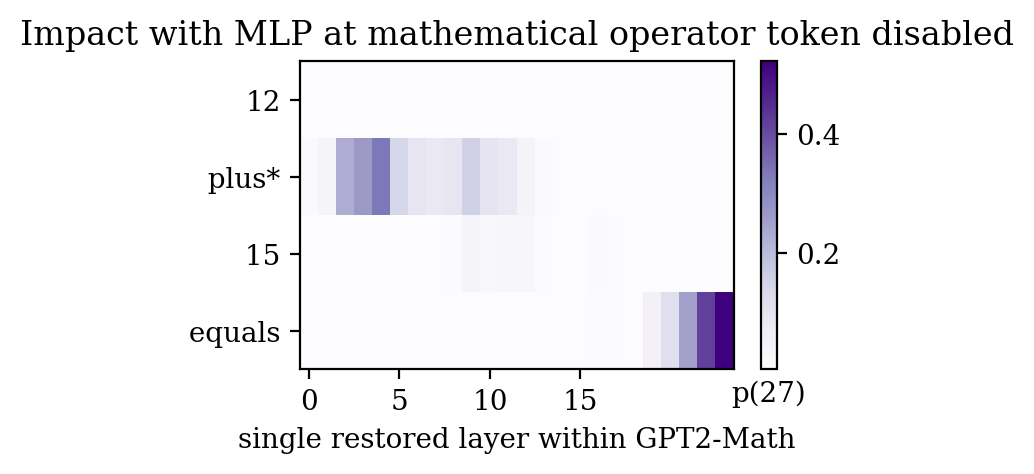

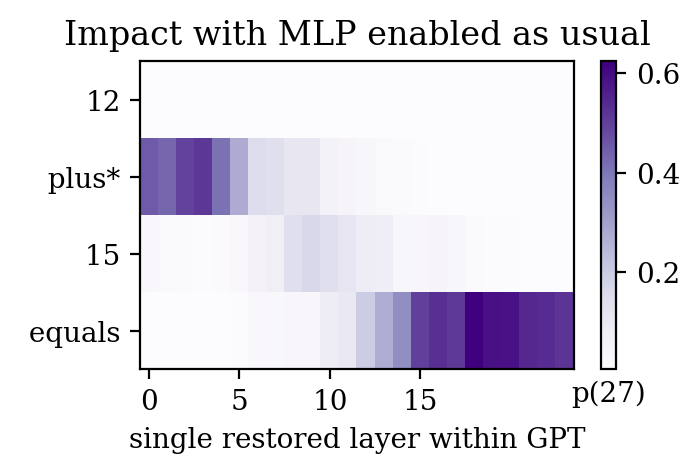

In [27]:
prefix = "12 plus 15 equals"
subject = "plus"

no_attn_r = calculate_hidden_flow_3(
    mt, prefix, subject, disable_mlp=True, noise=noise_level
)
plot_trace_heatmap(no_attn_r, title="Impact with MLP at mathematical operator token disabled", modelname="GPT2-Math")
ordinary_r = calculate_hidden_flow_3(mt, prefix, subject, noise=noise_level)
plot_trace_heatmap(ordinary_r, title="Impact with MLP enabled as usual")

## Comparing the with-MLP/Attn and without-MLP/Attn traces

Plotting on a bar graph makes it easier to see the difference between the causal effects with and without MLP enabled.

In [28]:
def plot_last_subject(mt, prefix, entity, token_range="last_subject", savepdf=None):
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt, prefix, entity, token_range=token_range
    )
    plot_comparison(ordinary, no_attn, no_mlp, prefix, savepdf=savepdf)


def calculate_last_subject(mt, prefix, entity, cache=None, token_range="last_subject"):
    def load_from_cache(filename):
        try:
            dat = numpy.load(f"{cache}/{filename}")
            return {
                k: v
                if not isinstance(v, numpy.ndarray)
                else str(v)
                if v.dtype.type is numpy.str_
                else torch.from_numpy(v)
                for k, v in dat.items()
            }
        except FileNotFoundError as e:
            return None

    no_attn_r = load_from_cache("no_attn_r.npz")
    uncached_no_attn_r = no_attn_r is None
    no_mlp_r = load_from_cache("no_mlp_r.npz")
    uncached_no_mlp_r = no_mlp_r is None
    ordinary_r = load_from_cache("ordinary.npz")
    uncached_ordinary_r = ordinary_r is None
    if uncached_no_attn_r:
        no_attn_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_attn=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_no_mlp_r:
        no_mlp_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_mlp=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_ordinary_r:
        ordinary_r = calculate_hidden_flow_3(
            mt, prefix, entity, token_range=token_range, noise=noise_level
        )
    if cache is not None:
        os.makedirs(cache, exist_ok=True)
        for u, r, filename in [
            (uncached_no_attn_r, no_attn_r, "no_attn_r.npz"),
            (uncached_no_mlp_r, no_mlp_r, "no_mlp_r.npz"),
            (uncached_ordinary_r, ordinary_r, "ordinary.npz"),
        ]:
            if u:
                numpy.savez(
                    f"{cache}/{filename}",
                    **{
                        k: v.cpu().numpy() if torch.is_tensor(v) else v
                        for k, v in r.items()
                    },
                )
    if False:
        return (ordinary_r["scores"][0], no_attn_r["scores"][0], no_mlp_r["scores"][0])
    return (
        ordinary_r["scores"][0] - ordinary_r["low_score"],
        no_attn_r["scores"][0] - ordinary_r["low_score"],
        no_mlp_r["scores"][0] - ordinary_r["low_score"],
    )

    # return ordinary_r['scores'][0], no_attn_r['scores'][0]


def plot_comparison(ordinary, no_attn, no_mlp, title, savepdf=None):
    with plt.rc_context(rc={"font.family": "DejaVu Serif"}):
        import matplotlib.ticker as mtick

        fig, ax = plt.subplots(1, figsize=(6, 1.5), dpi=300)
        ax.bar(
            [i - 0.3 for i in range(len(ordinary))],
            ordinary,
            width=0.3,
            color="#7261ab",
            label="Impact of single state on P",
        )
        ax.bar(
            [i for i in range(len(no_attn))],
            no_attn,
            width=0.3,
            color="#f3201b",
            label="Impact with Attn severed",
        )
        ax.bar(
            [i + 0.3 for i in range(len(no_mlp))],
            no_mlp,
            width=0.3,
            color="#20b020",
            label="Impact with MLP severed",
        )
        ax.set_title(
            title
        )  #'Impact of individual hidden state at last subject token with MLP disabled')
        ax.set_ylabel("Indirect Effect")
        # ax.set_xlabel('Layer at which the single hidden state is restored')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(None, max(0.025, ordinary.max() * 1.05))
        ax.legend()
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


if False:  # Some representative cases.
    plot_last_subject(mt, "Megan Rapinoe plays the sport of", "Megan Rapinoe")
    plot_last_subject(mt, "The Big Bang Theory premires on", "The Big Bang Theory")
    plot_last_subject(mt, "Germaine Greer's domain of work is", "Germaine Greer")
    plot_last_subject(mt, "Brian de Palma works in the area of", "Brian de Palma")
    plot_last_subject(mt, "The headquarter of Zillow is in downtown", "Zillow")
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi",
    )
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi Electric",
    )
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame")
    plot_last_subject(
        mt, "Madame de Montesson died in the city of", "Madame de Montesson"
    )
    plot_last_subject(mt, "Edmund Neupert, performing on the", "Edmund Neupert")

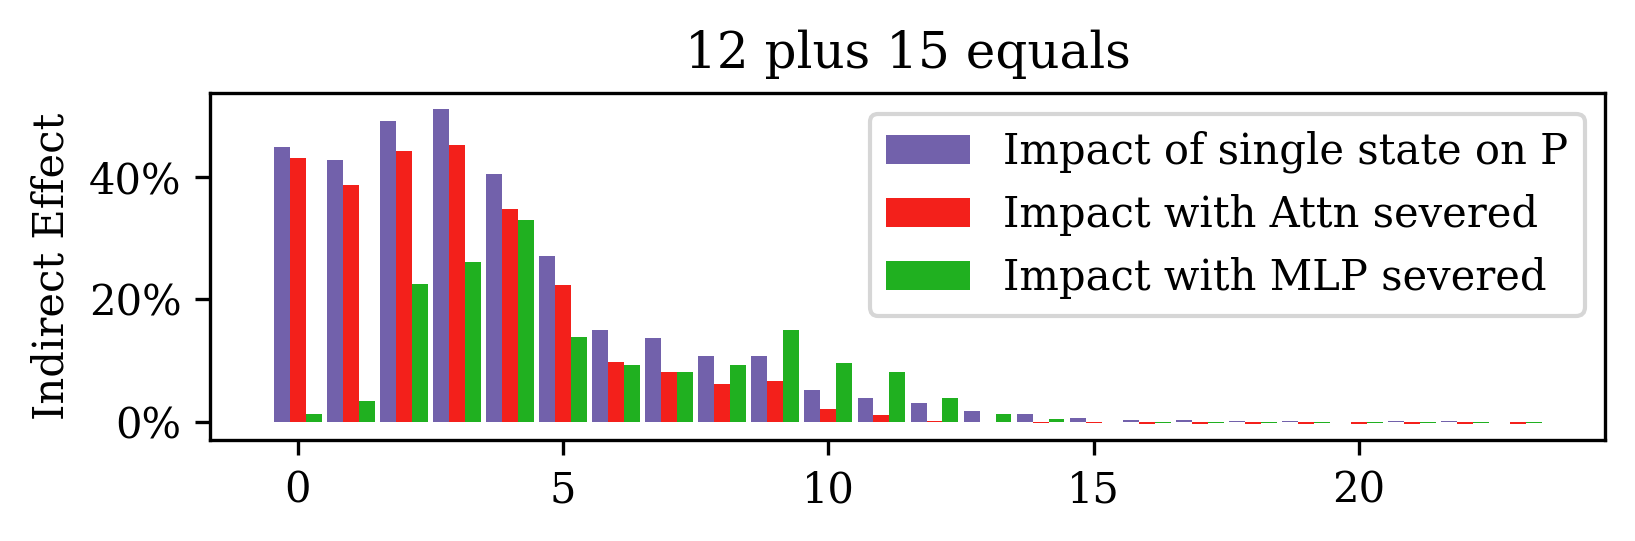

In [29]:
plot_last_subject(mt, "12 plus 15 equals", "plus")

## Average Indirect Effects

Now we average over the first 100 of the factual statements.

Loaded dataset with 763 elements


100%|██████████| 100/100 [00:00<00:00, 239.77it/s]


[tensor(-0.2641), tensor(-0.2524), tensor(-0.2146)]
tensor(0.0242) tensor(0.0267) tensor(0.0250)


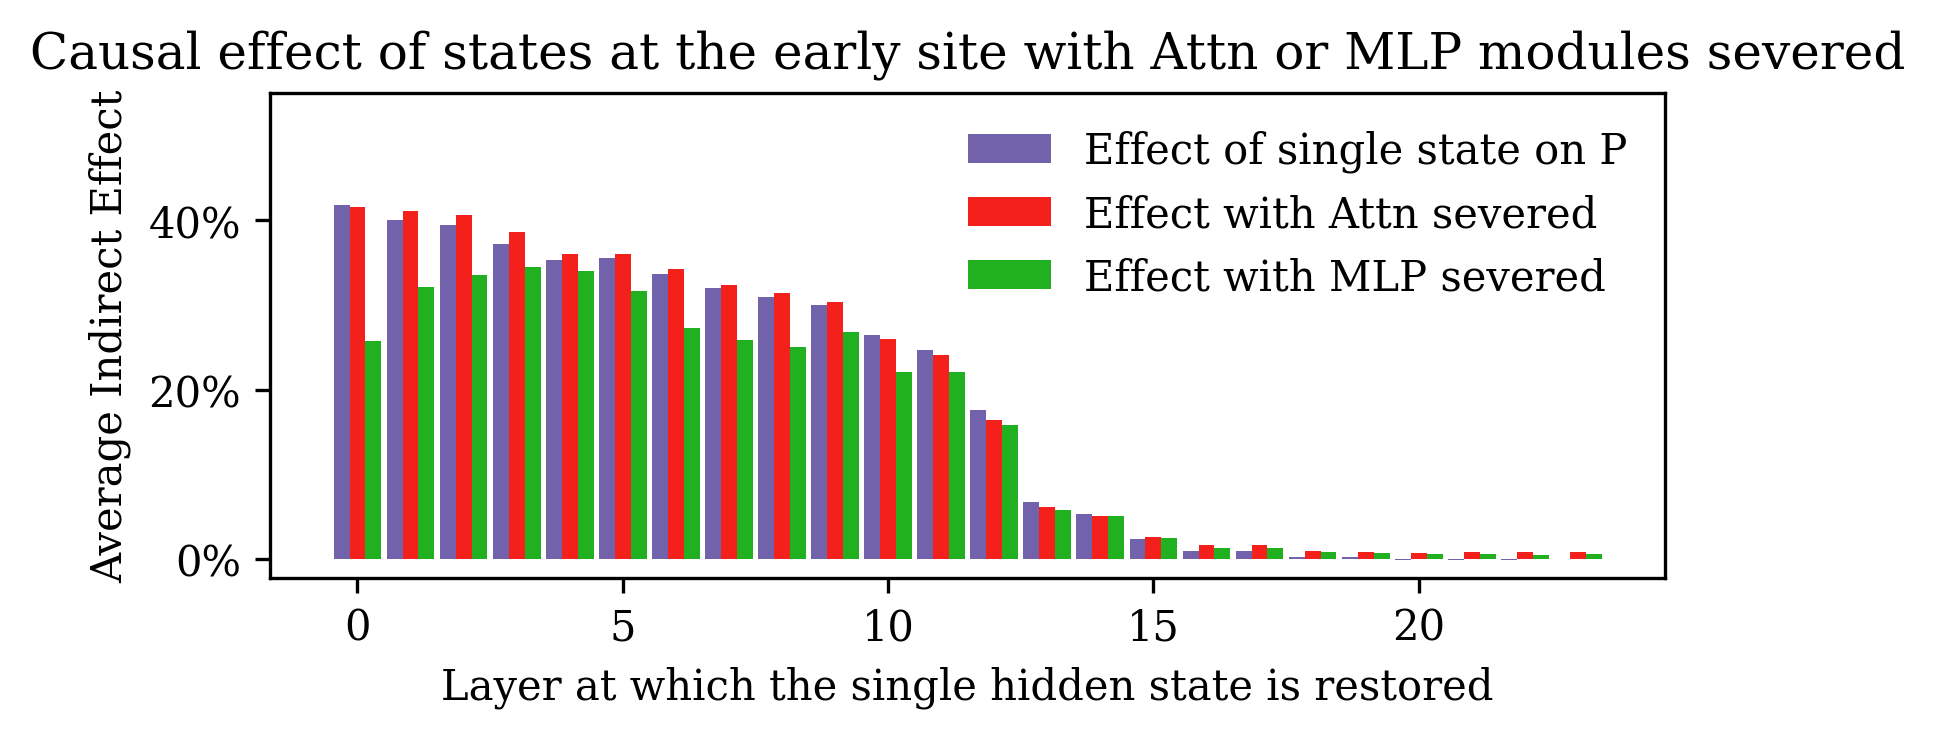

In [37]:
import tqdm

knowns = KnownsDataset("/content/rome/dsets")
all_ordinary = []
all_no_attn = []
all_no_mlp = []
for i, knowledge in enumerate(tqdm.tqdm(knowns[:100])):
    # plot_all_flow(mt, knowledge['prompt'], knowledge['subject'])
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt,
        knowledge["prompt"],
        knowledge["subject"],
        cache=f"results/ct_disable_attn/case_{i}",
    )
    all_ordinary.append(ordinary)
    all_no_attn.append(no_attn)
    all_no_mlp.append(no_mlp)
title = "Causal effect of states at the early site with Attn or MLP modules severed"

avg_ordinary = torch.stack(all_ordinary).mean(dim=0)
avg_no_attn = torch.stack(all_no_attn).mean(dim=0)
avg_no_mlp = torch.stack(all_no_mlp).mean(dim=0)
import matplotlib.ticker as mtick

with plt.rc_context(rc={"font.family": "DejaVu Serif"}):
    fig, ax = plt.subplots(1, figsize=(6, 2.1), dpi=300)
    ax.bar(
        [i - 0.3 for i in range(24)], # 24 layers for gpt2-medium
        avg_ordinary,
        width=0.3,
        color="#7261ab",
        label="Effect of single state on P",
    )
    ax.bar(
        [i for i in range(24)],
        avg_no_attn,
        width=0.3,
        color="#f3201b",
        label="Effect with Attn severed",
    )
    ax.bar(
        [i + 0.3 for i in range(24)],
        avg_no_mlp,
        width=0.3,
        color="#20b020",
        label="Effect with MLP severed",
    )
    ax.set_title(
        title
    )  #'Impact of individual hidden state at last subject token with MLP disabled')
    ax.set_ylabel("Average Indirect Effect")
    ax.set_xlabel("Layer at which the single hidden state is restored")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(None, max(0.025, 0.55))

    ax.legend(frameon=False)
fig.savefig("causal-trace-no-attn-mlp-math.pdf", bbox_inches="tight")
print([d[20] - d[10] for d in [avg_ordinary, avg_no_attn, avg_no_mlp]])
print(avg_ordinary[15], avg_no_attn[15], avg_no_mlp[15])

In [38]:
!zip -r results_frozen_mlp_gpt2-medium-math.zip /content/rome/results/ct_disable_attn


  adding: content/rome/results/ct_disable_attn/ (stored 0%)
  adding: content/rome/results/ct_disable_attn/case_32/ (stored 0%)
  adding: content/rome/results/ct_disable_attn/case_32/ordinary.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_32/no_attn_r.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_32/no_mlp_r.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_48/ (stored 0%)
  adding: content/rome/results/ct_disable_attn/case_48/ordinary.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_48/no_attn_r.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_48/no_mlp_r.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_25/ (stored 0%)
  adding: content/rome/results/ct_disable_attn/case_25/ordinary.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_25/no_attn_r.npz (deflated 73%)
  adding: content/rome/results/ct_disable_attn/case_25/no_mlp_r.npz (

In [39]:
!mv results_frozen_mlp_gpt2-medium-math.zip /content/drive/MyDrive/